# 2018-10-09 Ensemble, Gradient, Boosting...

Le noteboook explore quelques particularités des algorithmes d'apprentissage pour expliquer certains résultats numériques. L'algoithme [AdaBoost](https://fr.wikipedia.org/wiki/AdaBoost) surpondère les exemples sur lequel un modèle fait des erreurs.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Skewed split train test

Lorsqu'une classe est sous représentée, il est difficile de prédire les résultats d'un modèle de machine learning.

In [3]:
import numpy, numpy.random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix

N = 1000

res = []

for n in [1, 2, 5, 10, 20, 50, 80, 90, 100, 110]:
    print("n=", n)
    for k in range(10):

        X = numpy.zeros((N, 2))
        X[:, 0] = numpy.random.randint(0, 2, (N,))
        X[:, 1] = numpy.random.randint(0, n+1, (N,))
        Y = X[:, 0] + X[:, 1] + numpy.random.normal(size=(N,)) / 10
        Y[Y < 1.5] = 0
        Y[Y >= 1.5] = 1

        X_train, X_test, y_train, y_test = train_test_split(X, Y)

        stat = dict(N=N, n=n, ratio_train=y_train.sum()/y_train.shape[0],
                    k=k, ratio_test=y_test.sum()/y_test.shape[0])
        
        for model in [LogisticRegression(solver="liblinear"),
                      MLPClassifier(max_iter=500),
                      RandomForestClassifier(n_estimators=10),
                      AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=10)]:
            obs = stat.copy()
            obs["model"] = model.__class__.__name__
            if obs["model"] == "AdaBoostClassifier":
                obs["model"] = "AdaB-" + model.base_estimator.__class__.__name__
            try:
                model.fit(X_train, y_train)
            except ValueError as e:
                obs["erreur"] = str(e)
                res.append(obs)
                continue
            sc = model.score(X_test, y_test)
            obs["accuracy"] = sc
            conf = confusion_matrix(y_test, model.predict(X_test))
            try:
                obs["Error-0|1"] = conf[0, 1] / conf[0, :].sum()
                obs["Error-1|0"] = conf[1, 0] / conf[1, :].sum()
            except Exception:
                pass
            res.append(obs)

n= 1
n= 2
n= 5
n= 10
n= 20
n= 50
n= 80
n= 90
n= 100
n= 110


In [4]:
from pandas import DataFrame
df = DataFrame(res)
df = df.sort_values(['n', 'model', 'model', "k"]).reset_index(drop=True)
df["diff_ratio"] = (df["ratio_test"] - df["ratio_train"]).abs()
df.head(n=5)

,Error-0|1,Error-1|0,N,accuracy,k,model,n,ratio_test,ratio_train,diff_ratio
0,0.0,0.0,1000,1.0,0,AdaB-DecisionTreeClassifier,1,0.176,0.217333,0.041333
1,0.0,0.0,1000,1.0,1,AdaB-DecisionTreeClassifier,1,0.240,0.264000,0.024000
2,0.0,0.0,1000,1.0,2,AdaB-DecisionTreeClassifier,1,0.288,0.254667,0.033333
3,0.0,0.0,1000,1.0,3,AdaB-DecisionTreeClassifier,1,0.272,0.258667,0.013333
4,0.0,0.0,1000,1.0,4,AdaB-DecisionTreeClassifier,1,0.272,0.256000,0.016000


In [5]:
df.tail(n=5)

,Error-0|1,Error-1|0,N,accuracy,k,model,n,ratio_test,ratio_train,diff_ratio
395,0.0,0.0,1000,1.0,5,RandomForestClassifier,110,0.972,0.985333,0.013333
396,0.0,0.0,1000,1.0,6,RandomForestClassifier,110,0.988,0.986667,0.001333
397,0.0,0.0,1000,1.0,7,RandomForestClassifier,110,0.992,0.989333,0.002667
398,0.0,0.0,1000,1.0,8,RandomForestClassifier,110,0.980,0.981333,0.001333
399,0.0,0.0,1000,1.0,9,RandomForestClassifier,110,0.972,0.985333,0.013333


La répartition train/test est loin d'être statisfaisante lorsqu'il existe une classe sous représentée.

In [6]:
df[df.n==100][["n", "ratio_test", "ratio_train"]].head(n=10)

,n,ratio_test,ratio_train
320,100,0.980,0.982667
321,100,0.972,0.986667
322,100,0.992,0.974667
323,100,0.988,0.992000
324,100,0.996,0.985333
325,100,0.988,0.982667
326,100,0.980,0.978667
327,100,0.992,0.986667
328,100,0.984,0.984000
329,100,0.992,0.985333


In [7]:
#df.to_excel("data.xlsx")

In [8]:
columns = ["n", "N", "model"]
agg = df.groupby(columns, as_index=False).mean().sort_values(["n", "model"]).reset_index(drop=True)
agg.tail()

,n,N,model,Error-0|1,Error-1|0,accuracy,k,ratio_test,ratio_train,diff_ratio
35,100,1000,RandomForestClassifier,0.033333,0.0,0.9996,4.5,0.9864,0.983867,0.0068
36,110,1000,AdaB-DecisionTreeClassifier,0.000000,0.0,1.0000,4.5,0.9836,0.986533,0.0072
37,110,1000,LogisticRegression,0.221429,0.0,0.9964,4.5,0.9836,0.986533,0.0072
38,110,1000,MLPClassifier,0.078571,0.0,0.9988,4.5,0.9836,0.986533,0.0072
39,110,1000,RandomForestClassifier,0.000000,0.0,1.0000,4.5,0.9836,0.986533,0.0072


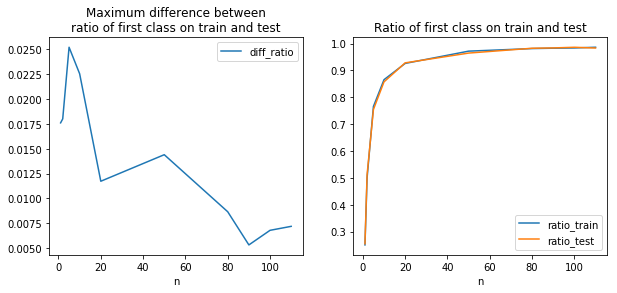

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,4))
agg.plot(x="n", y="diff_ratio", ax=ax[0])
agg.plot(x="n", y="ratio_train", ax=ax[1])
agg.plot(x="n", y="ratio_test", ax=ax[1])
ax[0].set_title("Maximum difference between\nratio of first class on train and test")
ax[1].set_title("Ratio of first class on train and test")
ax[0].legend();

Une astuce pour éviter les doublons avant d'effecturer un pivot.

In [10]:
agg2 = agg2.copy()
agg2["ratio_test2"] = agg2["ratio_test"] + agg2["n"] / 100000

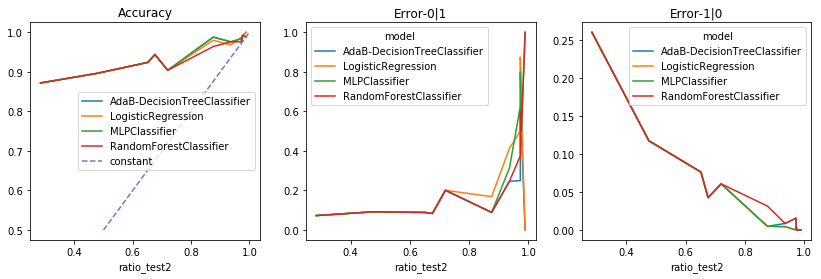

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(14,4))
agg2.pivot("ratio_test2", "model", "accuracy").plot(ax=ax[0])
agg2.pivot("ratio_test2", "model", "Error-0|1").plot(ax=ax[1])
agg2.pivot("ratio_test2", "model", "Error-1|0").plot(ax=ax[2])
ax[0].plot([0.5, 1.0], [0.5, 1.0], '--', label="constant")
ax[0].set_title("Accuracy")
ax[1].set_title("Error-0|1")
ax[2].set_title("Error-1|0")
ax[0].legend();

In [12]:
agg2.pivot("ratio_test2", "model", "Error-0|1")

model,AdaB-DecisionTreeClassifier,LogisticRegression,MLPClassifier,RandomForestClassifier
ratio_test2,,,,
0.28401,0.073027,0.073027,0.073027,0.073027
0.47602,0.092143,0.092143,0.092143,0.092143
0.65203,0.088768,0.088768,0.088768,0.088768
0.67604,0.083730,0.083730,0.083730,0.083730
0.72005,0.200932,0.200932,0.200932,0.200932
0.87610,0.088889,0.168889,0.088889,0.088889
0.93620,0.246667,0.413333,0.313333,0.246667
0.97290,0.250000,0.500000,0.625000,0.375000
0.97300,0.600000,0.875000,0.800000,0.600000


Le modèle [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) construit 10 arbres tout comme la forêt aléatoire à ceci près que le poids associé à chacun des arbres des différents et non uniforme.